In [9]:
#!apt-get update ; apt-get install -y graphviz libgraphviz-dev
#%pip install pydot
# %pip install tqdm
# %pip install pandas
# %pip install sklearn
# %pip install pillow
# %pip install seaborn
from tensorflow import keras
import tensorflow
import pandas as pd
import numpy as np
import functools
from time import time
import matplotlib.pyplot as plt
import math
from tensorflow.keras.preprocessing import image as imgproc
from sklearn.model_selection import train_test_split
from tensorflow.keras.layers import Conv2D, BatchNormalization, MaxPool2D, GlobalMaxPool2D, Flatten, AveragePooling2D, LSTM, ConvLSTM2D
from tensorflow.keras.layers import TimeDistributed, Bidirectional, GRU, Dense, Dropout, Conv3D, MaxPooling3D, GlobalMaxPool3D
from tensorflow.keras.utils import Sequence, OrderedEnqueuer
import tensorflow as tf
from glob import glob
from tqdm import tqdm
import numpy as np
from sklearn.utils import shuffle
from sklearn.metrics import mean_squared_error
import seaborn as sns
from tensorflow.keras.models import load_model
import matplotlib.pyplot as plt
import tempfile
from sklearn.preprocessing import MinMaxScaler
import os
import random
from datetime import datetime
%load_ext tensorboard
%matplotlib inline
print("Num GPUs Available:", len(tf.config.list_physical_devices('GPU')))
print("Tensorflow version:", tensorflow.__version__)

physical_devices = tf.config.experimental.list_physical_devices('GPU')
if len(physical_devices) > 0:
    tf.config.experimental.set_memory_growth(physical_devices[0], True)
    
# Attempt to make runs more reproducible
seed_value=20212042
print("Using seed value: %d" % seed_value)
os.environ['PYTHONHASHSEED']=str(seed_value)
random.seed(seed_value)
np.random.seed(seed_value)
tf.random.set_seed(seed_value) # tensorflow 2.x

The tensorboard extension is already loaded. To reload it, use:
  %reload_ext tensorboard
Num GPUs Available: 1
Tensorflow version: 2.4.0
Using seed value: 20212042


## Set Parameters

In [10]:
# set up paths
base_dir = "/workspace/C684_Assignment/"
processing_dir = os.path.join(base_dir, "processing")
frames_dir = os.path.join(processing_dir, "att_maps")
train_dir = os.path.join(base_dir, "training")
train_frame_dir = os.path.join(train_dir, "train_frames")
chkp_dir = os.path.join(train_dir, "chkp")
if not os.path.exists(chkp_dir):
    os.makedirs(chkp_dir)
logs_dir = os.path.join(train_dir, "logs")
if not os.path.exists(logs_dir):
    os.makedirs(logs_dir)
    
# some global params
SHORT_TERM_MODEL = False
SIZE = (70, 70)
USE_ATT_MAPS = False
USE_AMNET_PRED = True
ATT_MAPS = [ 0, 1, 2 ] # full list - [ 0, 1, 2 ]
RGB = True
FRAME_INDEXES = [0, 48, 96, 144] # full list - [0, 24, 48, 72, 96, 120, 144]
BATCH_SIZE=32
TRAINING_ITERATIONS=4
EPOCHS=20
MULTIPROCESSING=True
WORKERS=8
SPEARMAN_THRESHOLD = 0.43
CHANNELS = len(ATT_MAPS) * (3 if RGB else 1)
NBFRAME = len(FRAME_INDEXES)

## Load Train and Test Data

In [11]:
# load data
amnet_preds = pd.read_csv(os.path.join(processing_dir, "all_amnet_pred.csv")).set_index("video")
amnet_preds["Y_pred"] = MinMaxScaler().fit_transform(amnet_preds["Y_pred"].values.reshape(-1, 1))
display(amnet_preds["Y_pred"].describe())
dev_videos = pd.read_csv(os.path.join(processing_dir, "amnet_devset_preds.csv"))
dev_videos_train = dev_videos[dev_videos["test"]==False]
dev_videos_test = dev_videos[dev_videos["test"]==True]

count    224000.000000
mean          0.600106
std           0.160918
min           0.000000
25%           0.487308
50%           0.628983
75%           0.726435
max           1.000000
Name: Y_pred, dtype: float64

## Plot Ground Truth Memorability Histograms

Train size: 5100. Test size: 900


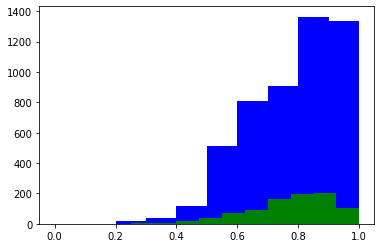

In [12]:
# train/test y_true histogram
X_train = dev_videos_train["video"]
y_train = dev_videos_train["short-term_memorability"] if SHORT_TERM_MODEL else dev_videos_train["long-term_memorability"]
X_test = dev_videos_test["video"]
y_test = dev_videos_test["short-term_memorability"] if SHORT_TERM_MODEL else dev_videos_test["long-term_memorability"]
train_size = X_train.shape[0]
test_size = X_test.shape[0]
print("Train size: %d. Test size: %d" % (train_size, test_size))
plt.hist(y_train, color='blue')
plt.hist(y_test, color='green')
plt.show()

## Calculate Baseline Performance

In [13]:
# calculate AMNet scores
def calc_spearman(a1, a2):
    Res = pd.DataFrame()
    Res["Y_true"] = a1
    Res["Y_pred"] = a2
    return Res[['Y_true','Y_pred']].corr(method='spearman',min_periods=1).iloc[1][0]

amnet_short_score = calc_spearman(dev_videos["short-term_memorability"], dev_videos["Y_pred"])
amnet_short_mse = mean_squared_error(dev_videos["short-term_memorability"], dev_videos["Y_pred"])
amnet_long_score = calc_spearman(dev_videos["long-term_memorability"], dev_videos["Y_pred"])
amnet_long_mse = mean_squared_error(dev_videos["long-term_memorability"], dev_videos["Y_pred"])
print("AMNet Overall: short-term score=%.04f|mse=%.04f, long-term score=%.04f|mse=%.04f"
      % (amnet_short_score, amnet_short_mse, amnet_long_score, amnet_long_mse))
amnet_short_score = calc_spearman(dev_videos_train["short-term_memorability"], dev_videos_train["Y_pred"])
amnet_short_mse = mean_squared_error(dev_videos_train["short-term_memorability"], dev_videos_train["Y_pred"])
amnet_long_score = calc_spearman(dev_videos_train["long-term_memorability"], dev_videos_train["Y_pred"])
amnet_long_mse = mean_squared_error(dev_videos_train["long-term_memorability"], dev_videos_train["Y_pred"])
print("AMNet Train: short-term score=%.04f|mse=%.04f, long-term score=%.04f|mse=%.04f"
      % (amnet_short_score, amnet_short_mse, amnet_long_score, amnet_long_mse))
amnet_short_score = calc_spearman(dev_videos_test["short-term_memorability"], dev_videos_test["Y_pred"])
amnet_short_mse = mean_squared_error(dev_videos_test["short-term_memorability"], dev_videos_test["Y_pred"])
amnet_long_score = calc_spearman(dev_videos_test["long-term_memorability"], dev_videos_test["Y_pred"])
amnet_long_mse = mean_squared_error(dev_videos_test["long-term_memorability"], dev_videos_test["Y_pred"])
print("AMNet Test: short-term score=%.04f|mse=%.04f, long-term score=%.04f|mse=%.04f"
      % (amnet_short_score, amnet_short_mse, amnet_long_score, amnet_long_mse))

AMNet Overall: short-term score=0.4183|mse=0.0194, long-term score=0.2143|mse=0.0232
AMNet Train: short-term score=0.4175|mse=0.0194, long-term score=0.2196|mse=0.0231
AMNet Test: short-term score=0.4214|mse=0.0195, long-term score=0.1867|mse=0.0235


## Define Generator and Callback Classes

In [14]:
class TrainTestSequence(Sequence):
    def __init__(self, X_set, y_set, do_shuffle):
        self.x, self.y = X_set, y_set
        self.do_shuffle = do_shuffle
        self.on_epoch_end()
        
    def __len__(self):
        return len(self.x) // BATCH_SIZE
    
    def _load_images(self, batch):
        images = np.zeros((len(batch), NBFRAME, SIZE[0], SIZE[1], CHANNELS))
        for video_index, video in enumerate(batch):
            for sequence_index, frame_index in enumerate(FRAME_INDEXES):
                filename = "%s_%d_att.jpg" % (video, frame_index)
                pilimg = []
                for img_index in ATT_MAPS:
                    dirname = "%s-%d" % (train_frame_dir, img_index)
                    img = imgproc.load_img(os.path.join(dirname, filename))
                    if not RGB:
                        img = img.convert('L')
                    img = img.resize(SIZE)
                    img = imgproc.img_to_array(img)
                    pilimg.append(img)
                images[video_index][sequence_index] = np.concatenate(pilimg, axis=2) / 255.
        return images
    
    def _load_amnet_preds(self, batch):
        batch_amnet_preds = np.zeros((len(batch), NBFRAME))
        for video_index, video in enumerate(batch):
            for sequence_index, frame_index in enumerate(FRAME_INDEXES):
                frame_id = "%s_%d" % (video, frame_index)
                batch_amnet_preds[video_index][sequence_index] = amnet_preds.loc[frame_id, "Y_pred"]
        return batch_amnet_preds
    
    def on_epoch_end(self):
        if self.do_shuffle:
            self.x, self.y = shuffle(self.x, self.y)
            
    def __getitem__(self, idx):
        batch_x = self.x[idx * BATCH_SIZE:(idx + 1) * BATCH_SIZE]
        batch_y = self.y[idx * BATCH_SIZE:(idx + 1) * BATCH_SIZE]
        batch_x_features = []
        if USE_ATT_MAPS:
            batch_x_features.append(self._load_images(batch_x))
        if USE_AMNET_PRED:
            batch_x_features.append(self._load_amnet_preds(batch_x))
        return batch_x_features, np.array(batch_y)

def make_generator(X_set, y_set, shuffle, worker_count):
    seq = TrainTestSequence(X_set, y_set, shuffle)
    enq = OrderedEnqueuer(seq, use_multiprocessing=MULTIPROCESSING, shuffle=shuffle)
    enq.start(workers=worker_count, max_queue_size=worker_count*20)
    return enq

class SpearmanCalcCallback(keras.callbacks.Callback):
    def __init__(self, X_test, y_test, batch_size, worker_count):
        batch_remainder = y_test.shape[0] % batch_size
        self.steps = y_test.shape[0] // batch_size
        self.y_test = y_test[:-batch_remainder]
        self.X_test = X_test[:-batch_remainder]
        self.worker_count = worker_count
        self.generator = make_generator(self.X_test, self.y_test, False, self.worker_count)
        
    def on_epoch_end(self, zero_based_epoch, logs=None):
        epoch = zero_based_epoch + 1
        y_pred = self.model.predict(self.generator.get(), steps=self.steps)
        
        # reset generator before next epoch
        self.generator.stop()
        self.generator.start(workers=self.worker_count)
        
        Res = pd.DataFrame()
        Res["Y_true"] = self.y_test
        Res["Y_pred"] = y_pred
        score_mat = Res[['Y_true','Y_pred']].corr(method='spearman',min_periods=1).iloc[1][0]
        print()
        print("*** Epoch %d: Spearman's correlation = %.4f" % (epoch, score_mat))
        mse = mean_squared_error(Res["Y_true"], Res["Y_pred"])
        print("*** Epoch %d: MSE = %.4f" % (epoch, mse))
        plt.hist(y_pred)
        plt.show()
            
        if score_mat > SPEARMAN_THRESHOLD:
            model_file = os.path.join(chkp_dir, "weights-%.04f-%s-%d.hdf5" % (score_mat, self.run_id, epoch))
            print("*** Saving model to file %s" % model_file)
            model.save(model_file)
        print()

    def set_run(self, run_id, model):
        timestamp = datetime.now().strftime("%d_%m_%Y_%H_%M")
        self.run_id = "%s-%d" % (timestamp, run_id)
        self.model = model
        return self
    
    def evaluate_model(self, model):
        self.set_run(0, model)
        self.on_epoch_end(-1)

## Define Model

In [15]:
# define model
def functional_model(shape=(NBFRAME,) + SIZE + (CHANNELS,)):
    frame_inputs = keras.Input(shape=shape)
    f = ConvLSTM2D(filters=20, kernel_size=(3, 3), padding='same',
                   return_sequences=True)(frame_inputs)
    f = MaxPooling3D(pool_size=(1, 2, 2), padding='same')(f)
    f = ConvLSTM2D(filters=10, kernel_size=(3, 3), padding='same',
                   return_sequences=True)(f)
    f = MaxPooling3D(pool_size=(1, 3, 3), padding='same')(f)
    f = ConvLSTM2D(filters=5, kernel_size=(3, 3), padding='same',
                   return_sequences=True)(f)
    f = MaxPooling3D(pool_size=(1, 2, 2), padding='same')(f)
    f = TimeDistributed(Flatten())(f)
    f = TimeDistributed(Dense(512))(f)
    f = TimeDistributed(Dropout(0.5))(f)
    f = TimeDistributed(Dense(64))(f)
    f = Flatten()(f)
    f = Dense(128)(f)
    pred_inputs = keras.Input(shape=(NBFRAME,1,))
    p = keras.layers.LSTM(32, return_sequences=True)(pred_inputs)
    p = keras.layers.LSTM(32, return_sequences=True)(p)
    p = Flatten()(p)
    p = Dense(128)(p)
    
    inputs = None
    if USE_ATT_MAPS and USE_AMNET_PRED:
        f = keras.layers.Average()([f, p])
        inputs = [frame_inputs, pred_inputs]
    elif USE_ATT_MAPS:
        inputs = [frame_inputs]
    elif USE_AMNET_PRED:
        f = p
        inputs = [pred_inputs]
    else:
        raise Exception("USE_ATT_MAPS and/or USE_AMNET_PRED needs to be True")

    f = keras.layers.BatchNormalization()(f)
    f = Dense(64)(f)
    f = Dense(1, activation='sigmoid')(f)
    model = keras.Model(inputs=inputs, outputs=f)
    
    # display layer information
    print(model.summary())
    keras.utils.plot_model(model)
    
    return model

## Train Model

Model: "model_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_10 (InputLayer)        [(None, 4, 1)]            0         
_________________________________________________________________
lstm_8 (LSTM)                (None, 4, 32)             4352      
_________________________________________________________________
lstm_9 (LSTM)                (None, 4, 32)             8320      
_________________________________________________________________
flatten_14 (Flatten)         (None, 128)               0         
_________________________________________________________________
dense_27 (Dense)             (None, 128)               16512     
_________________________________________________________________
batch_normalization_4 (Batch (None, 128)               512       
_________________________________________________________________
dense_28 (Dense)             (None, 64)                8256

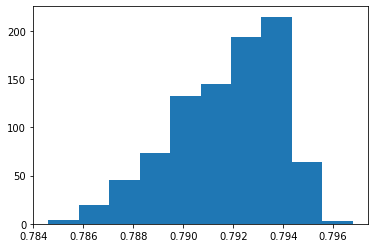


Epoch 2/20
159/159 [==============================] - 2s 15ms/step - loss: 0.0204

*** Epoch 2: Spearman's correlation = 0.1868
*** Epoch 2: MSE = 0.0206


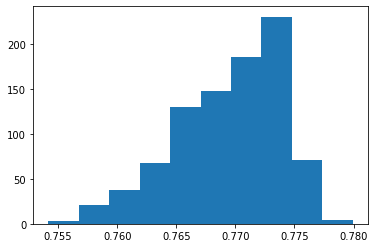


Epoch 3/20
159/159 [==============================] - 2s 15ms/step - loss: 0.0198

*** Epoch 3: Spearman's correlation = 0.1854
*** Epoch 3: MSE = 0.0202


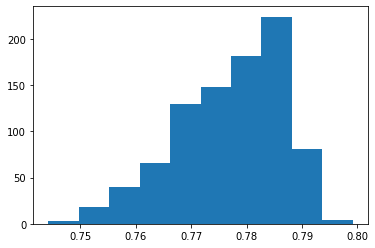


Epoch 4/20
159/159 [==============================] - 2s 13ms/step - loss: 0.0205

*** Epoch 3: Spearman's correlation = 0.1854
*** Epoch 3: MSE = 0.0202

*** Epoch 4: Spearman's correlation = 0.1861
*** Epoch 4: MSE = 0.0201


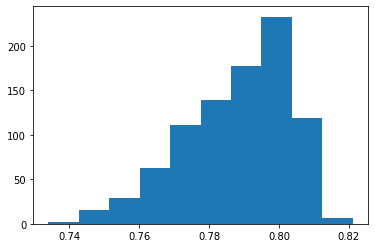


Epoch 5/20
159/159 [==============================] - 3s 16ms/step - loss: 0.0202

*** Epoch 5: Spearman's correlation = 0.1856
*** Epoch 5: MSE = 0.0221


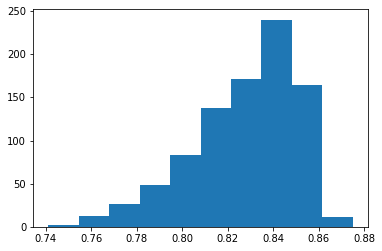


Epoch 6/20
159/159 [==============================] - 2s 13ms/step - loss: 0.0193

*** Epoch 6: Spearman's correlation = 0.1855
*** Epoch 6: MSE = 0.0202


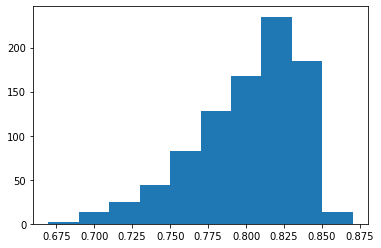


Epoch 7/20
159/159 [==============================] - 2s 13ms/step - loss: 0.0202
*** Epoch 6: MSE = 0.0202

*** Epoch 7: Spearman's correlation = 0.1842
*** Epoch 7: MSE = 0.0200


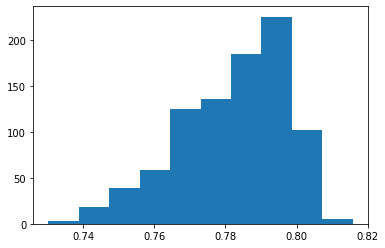


Epoch 8/20
159/159 [==============================] - 2s 14ms/step - loss: 0.0200
*** Epoch 7: Spearman's correlation = 0.1842
*** Epoch 7: MSE = 0.0200

*** Epoch 8: Spearman's correlation = 0.1854
*** Epoch 8: MSE = 0.0197


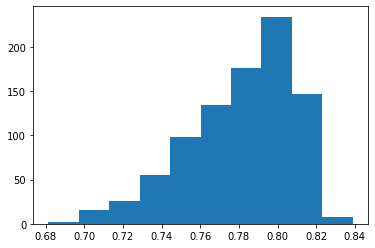


Epoch 9/20
159/159 [==============================] - 3s 17ms/step - loss: 0.0201

*** Epoch 9: Spearman's correlation = 0.1853
*** Epoch 9: MSE = 0.0212


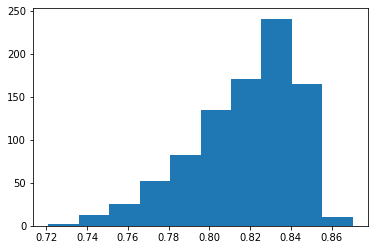


Epoch 10/20
159/159 [==============================] - 2s 13ms/step - loss: 0.0200

*** Epoch 9: Spearman's correlation = 0.1853

*** Epoch 10: Spearman's correlation = 0.1845
*** Epoch 10: MSE = 0.0201


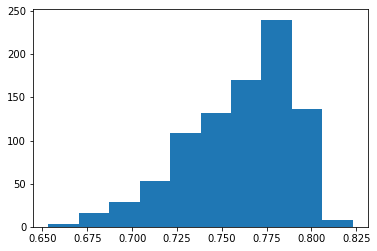


Epoch 11/20
159/159 [==============================] - 2s 14ms/step - loss: 0.0202

*** Epoch 11: Spearman's correlation = 0.1836
*** Epoch 11: MSE = 0.0200


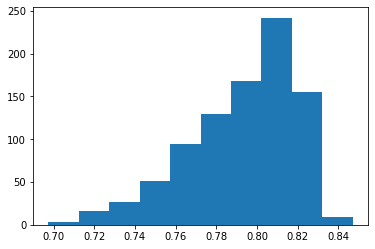


Epoch 12/20
159/159 [==============================] - 2s 13ms/step - loss: 0.0193

*** Epoch 12: Spearman's correlation = 0.1850
*** Epoch 12: MSE = 0.0203


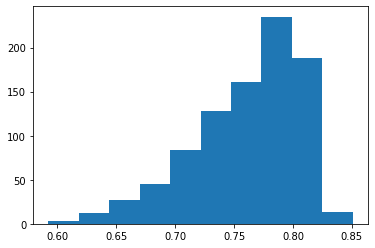


Epoch 13/20
159/159 [==============================] - 2s 14ms/step - loss: 0.0199

*** Epoch 13: Spearman's correlation = 0.1849
*** Epoch 13: MSE = 0.0199


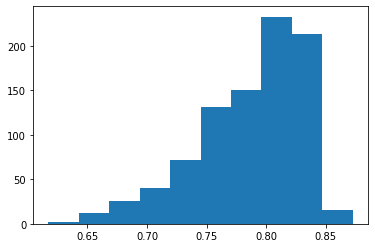


Epoch 14/20
159/159 [==============================] - 2s 13ms/step - loss: 0.0209

*** Epoch 14: Spearman's correlation = 0.1866
*** Epoch 14: MSE = 0.0280


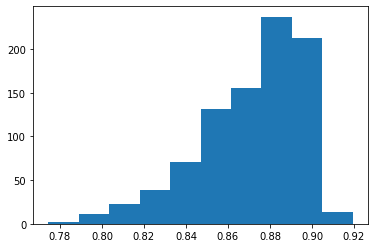


Epoch 15/20
159/159 [==============================] - 2s 13ms/step - loss: 0.0199

*** Epoch 15: Spearman's correlation = 0.1856
*** Epoch 15: MSE = 0.0211


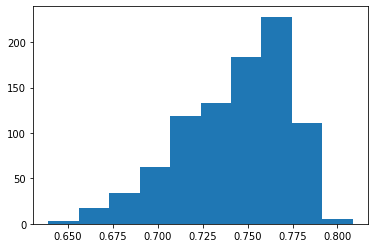


Epoch 16/20
159/159 [==============================] - 2s 14ms/step - loss: 0.0200

*** Epoch 16: Spearman's correlation = 0.1854
*** Epoch 16: MSE = 0.0212


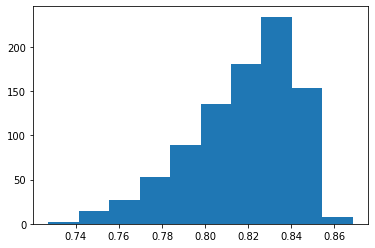


Epoch 17/20
159/159 [==============================] - 2s 13ms/step - loss: 0.0205

*** Epoch 16: Spearman's correlation = 0.1854

*** Epoch 17: Spearman's correlation = 0.1839
*** Epoch 17: MSE = 0.0243


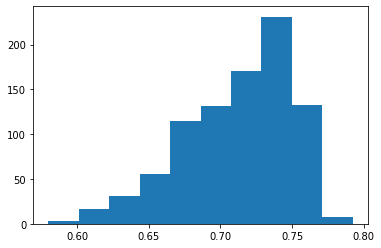


Epoch 18/20
159/159 [==============================] - 2s 13ms/step - loss: 0.0204

*** Epoch 17: Spearman's correlation = 0.1839
*** Epoch 17: MSE = 0.0243

*** Epoch 18: Spearman's correlation = 0.1855
*** Epoch 18: MSE = 0.0203


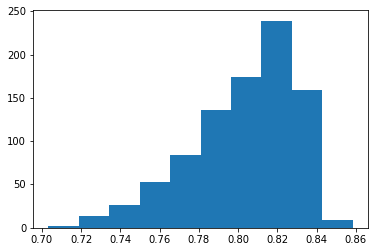


Epoch 19/20
159/159 [==============================] - 2s 14ms/step - loss: 0.0191

*** Epoch 19: Spearman's correlation = 0.1853
*** Epoch 19: MSE = 0.0203


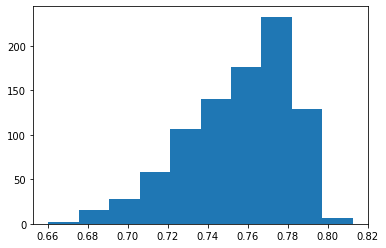


Epoch 20/20
159/159 [==============================] - 2s 13ms/step - loss: 0.0205

*** Epoch 20: Spearman's correlation = 0.1858
*** Epoch 20: MSE = 0.0393


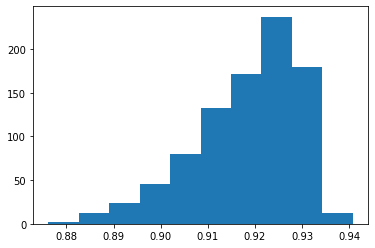


Model: "model_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_12 (InputLayer)        [(None, 4, 1)]            0         
_________________________________________________________________
lstm_10 (LSTM)               (None, 4, 32)             4352      
_________________________________________________________________
lstm_11 (LSTM)               (None, 4, 32)             8320      
_________________________________________________________________
flatten_17 (Flatten)         (None, 128)               0         
_________________________________________________________________
dense_33 (Dense)             (None, 128)               16512     
_________________________________________________________________
batch_normalization_5 (Batch (None, 128)               512       
_________________________________________________________________
dense_34 (Dense)             (None, 64)                825

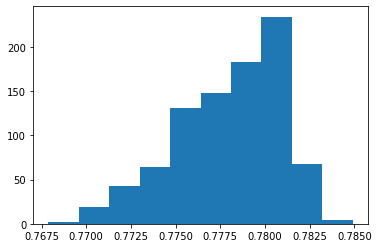


Epoch 2/20
159/159 [==============================] - 3s 21ms/step - loss: 0.0195
*** Epoch 1: Spearman's correlation = 0.1858
*** Epoch 1: MSE = 0.0205

*** Epoch 2: Spearman's correlation = 0.1857
*** Epoch 2: MSE = 0.0206


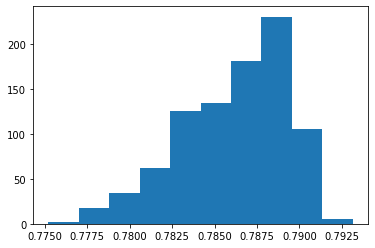


Epoch 3/20
159/159 [==============================] - 3s 18ms/step - loss: 0.0194

*** Epoch 2: Spearman's correlation = 0.1857

*** Epoch 3: Spearman's correlation = 0.1856
*** Epoch 3: MSE = 0.0206


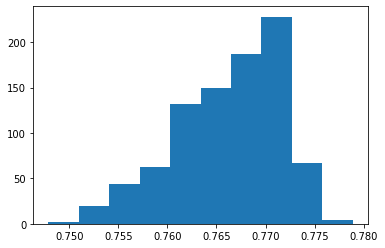


Epoch 4/20
159/159 [==============================] - 3s 18ms/step - loss: 0.0205

*** Epoch 3: MSE = 0.0206

*** Epoch 4: Spearman's correlation = 0.1856
*** Epoch 4: MSE = 0.0199


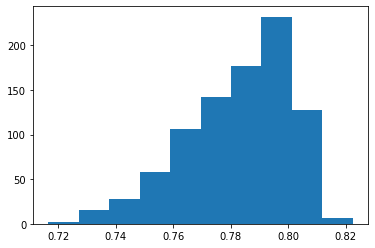


Epoch 5/20
159/159 [==============================] - 3s 19ms/step - loss: 0.0202

*** Epoch 5: Spearman's correlation = 0.1851
*** Epoch 5: MSE = 0.0198


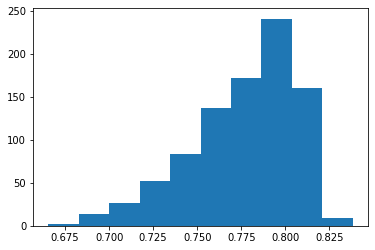


Epoch 6/20
159/159 [==============================] - 3s 18ms/step - loss: 0.0203


*** Epoch 6: Spearman's correlation = 0.1852
*** Epoch 6: MSE = 0.0199


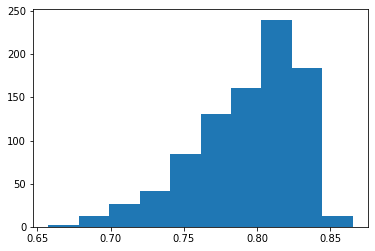


Epoch 7/20
159/159 [==============================] - 3s 20ms/step - loss: 0.0202

*** Epoch 7: Spearman's correlation = 0.1854
*** Epoch 7: MSE = 0.0211


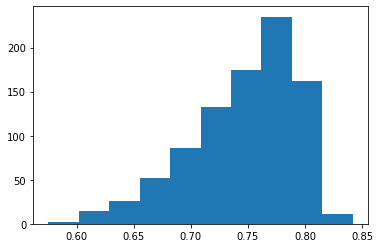


Epoch 8/20
159/159 [==============================] - 3s 19ms/step - loss: 0.0199

*** Epoch 8: Spearman's correlation = 0.1853
*** Epoch 8: MSE = 0.0203


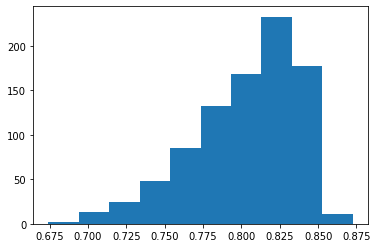


Epoch 9/20
159/159 [==============================] - 3s 19ms/step - loss: 0.0201

*** Epoch 8: Spearman's correlation = 0.1853
*** Epoch 8: MSE = 0.0203

*** Epoch 9: Spearman's correlation = 0.1844
*** Epoch 9: MSE = 0.0205


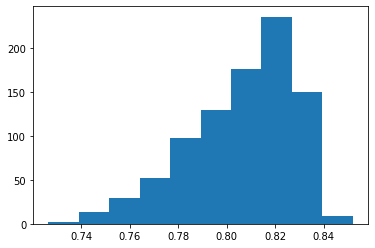


Epoch 10/20
159/159 [==============================] - 3s 19ms/step - loss: 0.0199
*** Epoch 9: MSE = 0.0205

*** Epoch 10: Spearman's correlation = 0.1843
*** Epoch 10: MSE = 0.0215


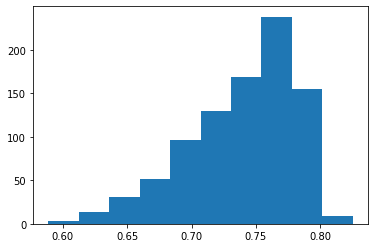


Epoch 11/20
159/159 [==============================] - 3s 20ms/step - loss: 0.0199
*** Epoch 10: Spearman's correlation = 0.1843

*** Epoch 11: Spearman's correlation = 0.1854
*** Epoch 11: MSE = 0.0233


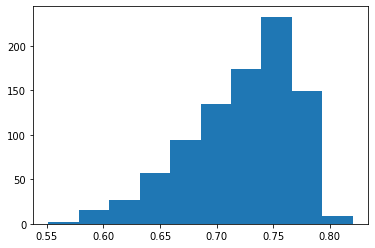


Epoch 12/20
159/159 [==============================] - 3s 19ms/step - loss: 0.0197

*** Epoch 11: Spearman's correlation = 0.1854
*** Epoch 11: MSE = 0.0233

*** Epoch 12: Spearman's correlation = 0.1847
*** Epoch 12: MSE = 0.0199


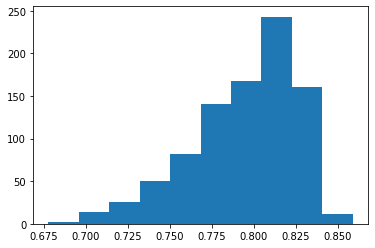


Epoch 13/20
159/159 [==============================] - 3s 19ms/step - loss: 0.0206
*** Epoch 12: Spearman's correlation = 0.1847
*** Epoch 12: MSE = 0.0199

*** Epoch 13: Spearman's correlation = 0.1846
*** Epoch 13: MSE = 0.0198


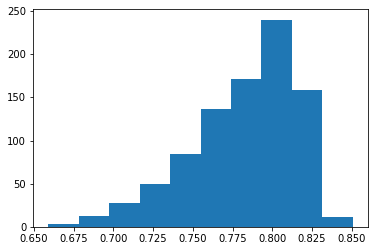


Epoch 14/20
159/159 [==============================] - 3s 20ms/step - loss: 0.0202

*** Epoch 14: Spearman's correlation = 0.1859
*** Epoch 14: MSE = 0.0199


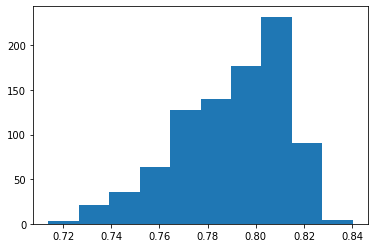


Epoch 15/20
159/159 [==============================] - 3s 19ms/step - loss: 0.0193

*** Epoch 15: Spearman's correlation = 0.1849
*** Epoch 15: MSE = 0.0220


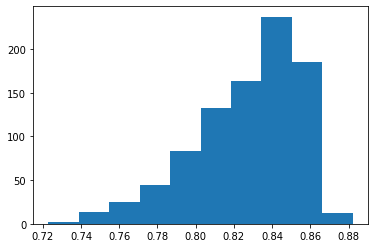


Epoch 16/20
159/159 [==============================] - 3s 20ms/step - loss: 0.0207

*** Epoch 16: Spearman's correlation = 0.1850
*** Epoch 16: MSE = 0.0198


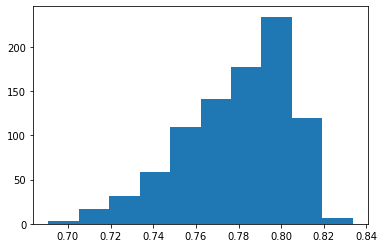


Epoch 17/20
159/159 [==============================] - 3s 19ms/step - loss: 0.0199

*** Epoch 16: Spearman's correlation = 0.1850
*** Epoch 16: MSE = 0.0198

*** Epoch 17: Spearman's correlation = 0.1844
*** Epoch 17: MSE = 0.0407


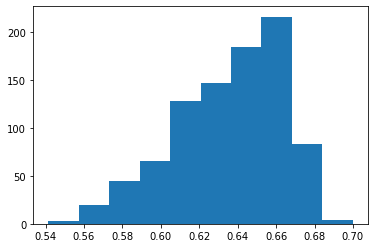


Epoch 18/20
159/159 [==============================] - 3s 18ms/step - loss: 0.0205

*** Epoch 17: Spearman's correlation = 0.1844

*** Epoch 18: Spearman's correlation = 0.1850
*** Epoch 18: MSE = 0.0218


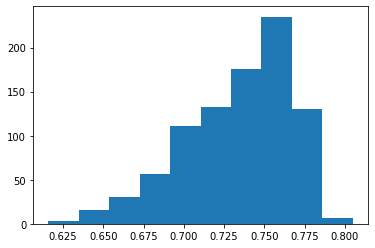


Epoch 19/20
159/159 [==============================] - 3s 19ms/step - loss: 0.0198

*** Epoch 18: Spearman's correlation = 0.1850
*** Epoch 18: MSE = 0.0218

*** Epoch 19: Spearman's correlation = 0.1850
*** Epoch 19: MSE = 0.0361


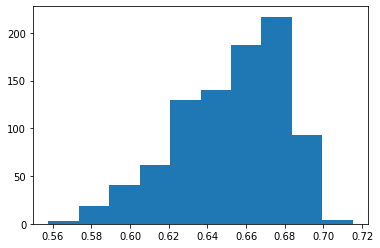


Epoch 20/20
159/159 [==============================] - 3s 19ms/step - loss: 0.0193

*** Epoch 20: Spearman's correlation = 0.1853
*** Epoch 20: MSE = 0.0215


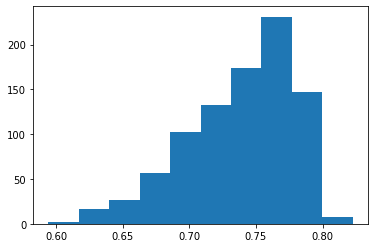


Model: "model_6"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_14 (InputLayer)        [(None, 4, 1)]            0         
_________________________________________________________________
lstm_12 (LSTM)               (None, 4, 32)             4352      
_________________________________________________________________
lstm_13 (LSTM)               (None, 4, 32)             8320      
_________________________________________________________________
flatten_20 (Flatten)         (None, 128)               0         
_________________________________________________________________
dense_39 (Dense)             (None, 128)               16512     
_________________________________________________________________
batch_normalization_6 (Batch (None, 128)               512       
_________________________________________________________________
dense_40 (Dense)             (None, 64)                825

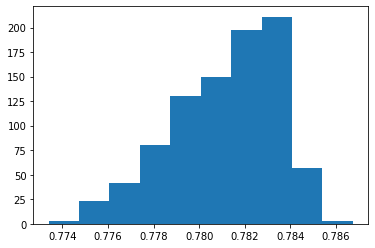


Epoch 2/20
159/159 [==============================] - 3s 21ms/step - loss: 0.0203
*** Epoch 1: MSE = 0.0206

*** Epoch 2: Spearman's correlation = 0.1856
*** Epoch 2: MSE = 0.0205


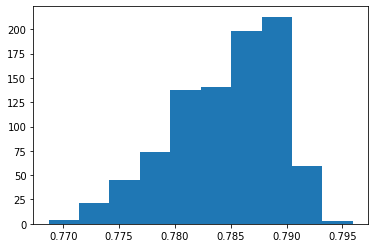


Epoch 3/20
159/159 [==============================] - 3s 19ms/step - loss: 0.0196

*** Epoch 3: Spearman's correlation = 0.1851
*** Epoch 3: MSE = 0.0202


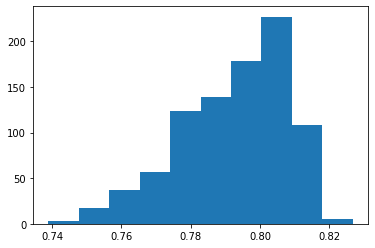


Epoch 4/20
159/159 [==============================] - 3s 20ms/step - loss: 0.0201

*** Epoch 4: Spearman's correlation = 0.1851
*** Epoch 4: MSE = 0.0201


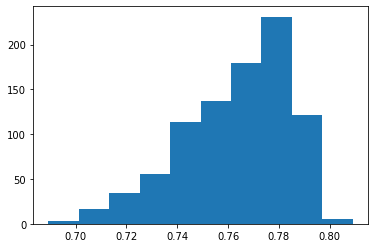


Epoch 5/20
159/159 [==============================] - 3s 19ms/step - loss: 0.0199

*** Epoch 4: Spearman's correlation = 0.1851
*** Epoch 4: MSE = 0.0201

*** Epoch 5: Spearman's correlation = 0.1739
*** Epoch 5: MSE = 0.0216


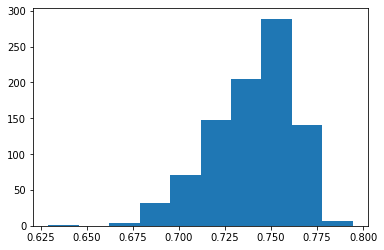


Epoch 6/20
159/159 [==============================] - 3s 18ms/step - loss: 0.0198

*** Epoch 5: Spearman's correlation = 0.1739

*** Epoch 6: Spearman's correlation = 0.1858
*** Epoch 6: MSE = 0.0214


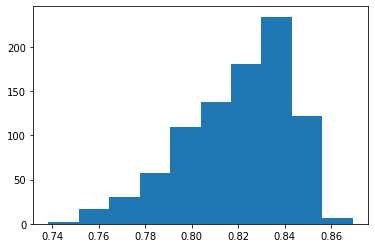


Epoch 7/20
159/159 [==============================] - 4s 22ms/step - loss: 0.0200


*** Epoch 7: Spearman's correlation = 0.1850
*** Epoch 7: MSE = 0.0216


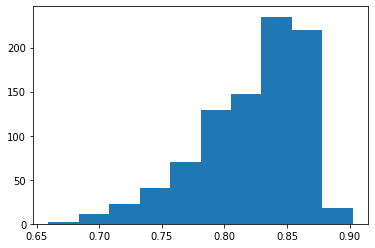


Epoch 8/20
159/159 [==============================] - 3s 20ms/step - loss: 0.0201


*** Epoch 8: Spearman's correlation = 0.1850
*** Epoch 8: MSE = 0.0212


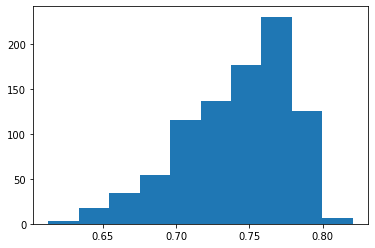


Epoch 9/20
159/159 [==============================] - 3s 20ms/step - loss: 0.0206

*** Epoch 8: Spearman's correlation = 0.1850WARNING:tensorflow:multiprocessing can interact badly with TensorFlow, causing nondeterministic deadlocks. For high performance data pipelines tf.data is recommended.

*** Epoch 9: Spearman's correlation = 0.1848
*** Epoch 9: MSE = 0.0200


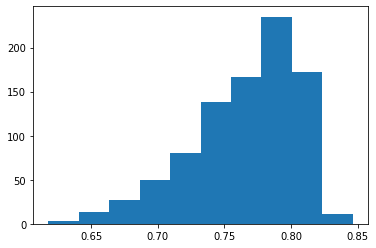


Epoch 10/20
159/159 [==============================] - 3s 19ms/step - loss: 0.0196
*** Epoch 9: MSE = 0.0200

*** Epoch 10: Spearman's correlation = 0.1838
*** Epoch 10: MSE = 0.0216


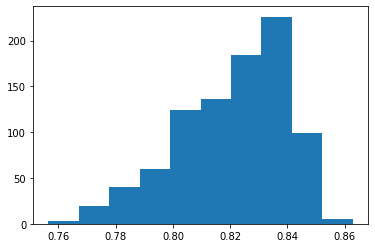


Epoch 11/20
159/159 [==============================] - 3s 20ms/step - loss: 0.0205

*** Epoch 10: Spearman's correlation = 0.1838
*** Epoch 10: MSE = 0.0216

*** Epoch 11: Spearman's correlation = 0.1857
*** Epoch 11: MSE = 0.0198


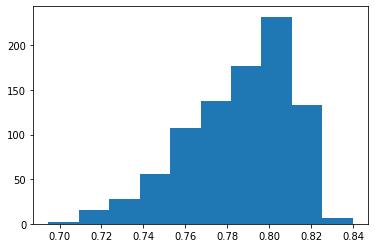


Epoch 12/20
159/159 [==============================] - 3s 19ms/step - loss: 0.0200


*** Epoch 12: Spearman's correlation = 0.1857
*** Epoch 12: MSE = 0.0199


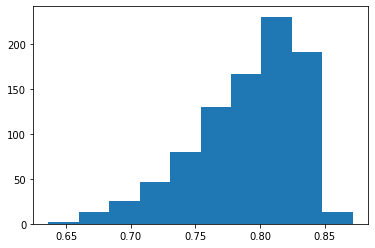


Epoch 13/20
159/159 [==============================] - 3s 18ms/step - loss: 0.0205

*** Epoch 13: Spearman's correlation = 0.1844
*** Epoch 13: MSE = 0.0213


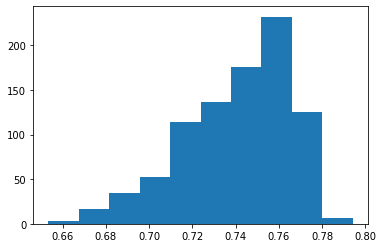


Epoch 14/20
159/159 [==============================] - 3s 19ms/step - loss: 0.0202

*** Epoch 13: Spearman's correlation = 0.1844
*** Epoch 13: MSE = 0.0213

*** Epoch 14: Spearman's correlation = 0.1861
*** Epoch 14: MSE = 0.0198


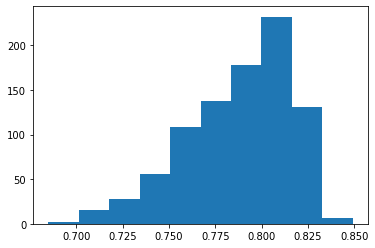


Epoch 15/20
159/159 [==============================] - 3s 19ms/step - loss: 0.0203
*** Epoch 14: MSE = 0.0198

*** Epoch 15: Spearman's correlation = 0.1851
*** Epoch 15: MSE = 0.0198


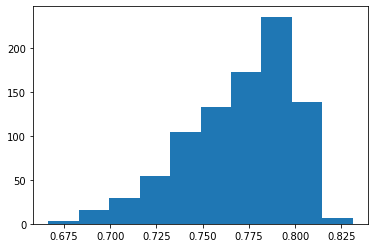


Epoch 16/20
159/159 [==============================] - 3s 19ms/step - loss: 0.0198

*** Epoch 15: Spearman's correlation = 0.1851
*** Epoch 15: MSE = 0.0198

*** Epoch 16: Spearman's correlation = 0.1856
*** Epoch 16: MSE = 0.0201


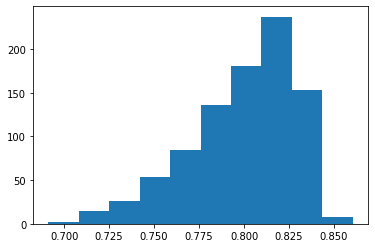


Epoch 17/20
159/159 [==============================] - 3s 19ms/step - loss: 0.0202

*** Epoch 17: Spearman's correlation = 0.1855
*** Epoch 17: MSE = 0.0201


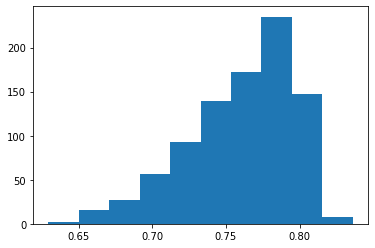


Epoch 18/20
159/159 [==============================] - 3s 20ms/step - loss: 0.0195

*** Epoch 18: Spearman's correlation = 0.1852
*** Epoch 18: MSE = 0.0215


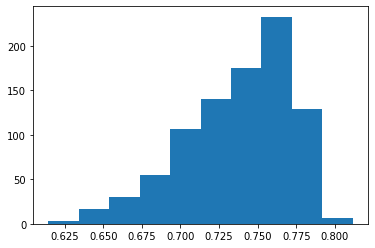


Epoch 19/20
159/159 [==============================] - 3s 19ms/step - loss: 0.0198

*** Epoch 18: Spearman's correlation = 0.1852

*** Epoch 19: Spearman's correlation = 0.1851
*** Epoch 19: MSE = 0.0199


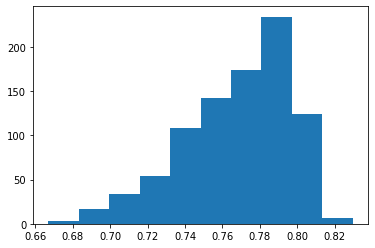


Epoch 20/20
159/159 [==============================] - 3s 20ms/step - loss: 0.0198

*** Epoch 20: Spearman's correlation = 0.1852
*** Epoch 20: MSE = 0.0198


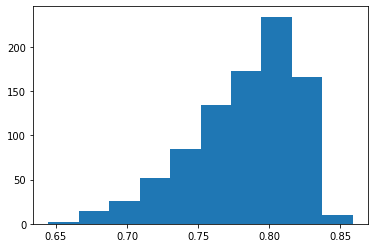


Model: "model_7"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_16 (InputLayer)        [(None, 4, 1)]            0         
_________________________________________________________________
lstm_14 (LSTM)               (None, 4, 32)             4352      
_________________________________________________________________
lstm_15 (LSTM)               (None, 4, 32)             8320      
_________________________________________________________________
flatten_23 (Flatten)         (None, 128)               0         
_________________________________________________________________
dense_45 (Dense)             (None, 128)               16512     
_________________________________________________________________
batch_normalization_7 (Batch (None, 128)               512       
_________________________________________________________________
dense_46 (Dense)             (None, 64)                825

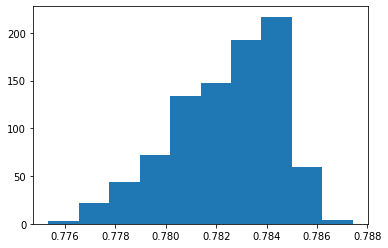


Epoch 2/20
159/159 [==============================] - 3s 19ms/step - loss: 0.0197

*** Epoch 2: Spearman's correlation = 0.1867
*** Epoch 2: MSE = 0.0206


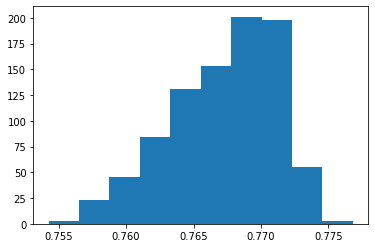


Epoch 3/20
159/159 [==============================] - 3s 18ms/step - loss: 0.0203

*** Epoch 3: Spearman's correlation = 0.1854
*** Epoch 3: MSE = 0.0206


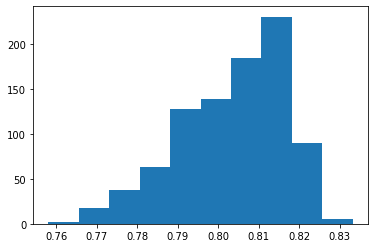


Epoch 4/20
159/159 [==============================] - 3s 21ms/step - loss: 0.0195

*** Epoch 4: Spearman's correlation = 0.1847
*** Epoch 4: MSE = 0.0211


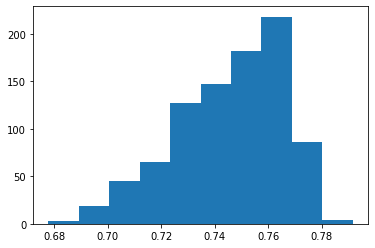


Epoch 5/20
159/159 [==============================] - 3s 19ms/step - loss: 0.0199

*** Epoch 5: Spearman's correlation = 0.1854
*** Epoch 5: MSE = 0.0206


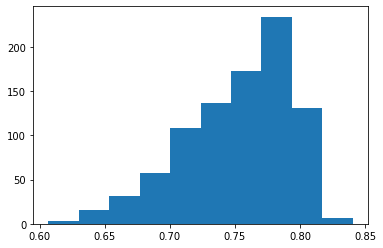


Epoch 6/20
159/159 [==============================] - 3s 19ms/step - loss: 0.0204

*** Epoch 6: Spearman's correlation = 0.1854
*** Epoch 6: MSE = 0.0228


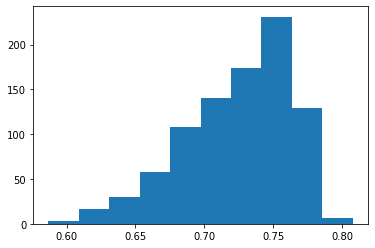


Epoch 7/20
159/159 [==============================] - 3s 19ms/step - loss: 0.0196

*** Epoch 7: Spearman's correlation = 0.1833
*** Epoch 7: MSE = 0.0212


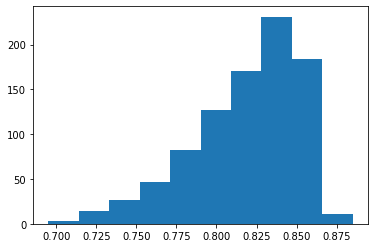


Epoch 8/20
159/159 [==============================] - 4s 22ms/step - loss: 0.0198

*** Epoch 8: Spearman's correlation = 0.1854
*** Epoch 8: MSE = 0.0222


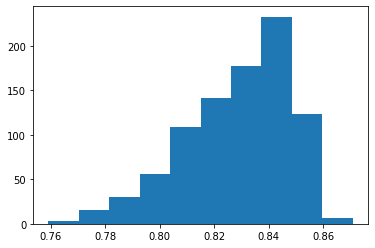


Epoch 9/20
159/159 [==============================] - 3s 20ms/step - loss: 0.0196

*** Epoch 9: Spearman's correlation = 0.1836
*** Epoch 9: MSE = 0.0316


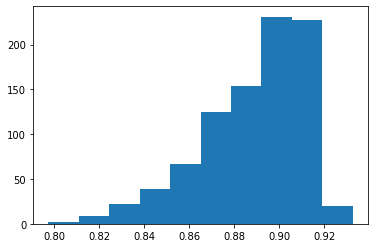


Epoch 10/20
159/159 [==============================] - 4s 24ms/step - loss: 0.0200

*** Epoch 10: Spearman's correlation = 0.1826
*** Epoch 10: MSE = 0.0198


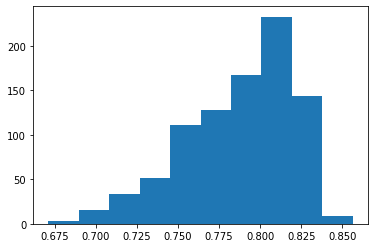


Epoch 11/20
159/159 [==============================] - 4s 22ms/step - loss: 0.0195

*** Epoch 11: Spearman's correlation = 0.1831
*** Epoch 11: MSE = 0.0207


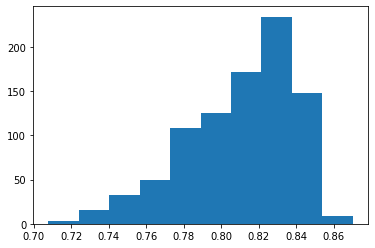


Epoch 12/20
159/159 [==============================] - 3s 20ms/step - loss: 0.0204

*** Epoch 12: Spearman's correlation = 0.1824
*** Epoch 12: MSE = 0.0205


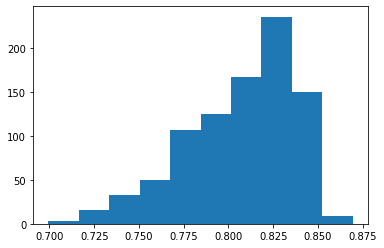


Epoch 13/20
159/159 [==============================] - 3s 21ms/step - loss: 0.0201

*** Epoch 13: Spearman's correlation = 0.1825
*** Epoch 13: MSE = 0.0198


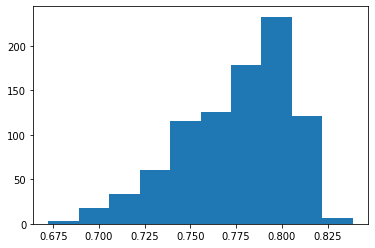


Epoch 14/20
159/159 [==============================] - 4s 22ms/step - loss: 0.0202

*** Epoch 14: Spearman's correlation = 0.1842
*** Epoch 14: MSE = 0.0200


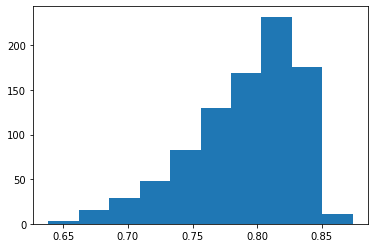


Epoch 15/20
159/159 [==============================] - 3s 21ms/step - loss: 0.0210

*** Epoch 15: Spearman's correlation = 0.1859
*** Epoch 15: MSE = 0.0226


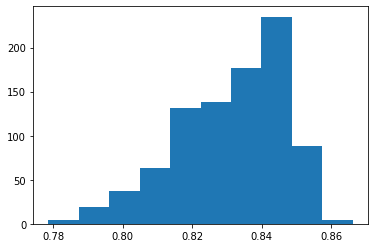


Epoch 16/20
159/159 [==============================] - 3s 20ms/step - loss: 0.0203

*** Epoch 16: Spearman's correlation = 0.1845
*** Epoch 16: MSE = 0.0263


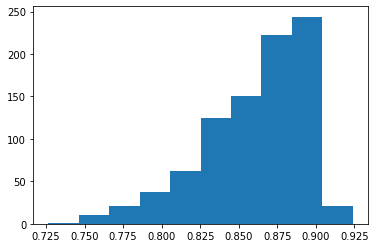


Epoch 17/20
159/159 [==============================] - 3s 20ms/step - loss: 0.0201

*** Epoch 17: Spearman's correlation = 0.1832
*** Epoch 17: MSE = 0.0224


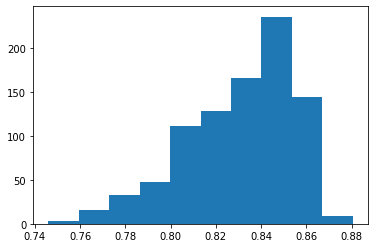


Epoch 18/20
159/159 [==============================] - 3s 19ms/step - loss: 0.0210

*** Epoch 18: Spearman's correlation = 0.1844
*** Epoch 18: MSE = 0.0198


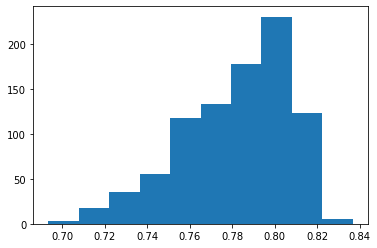


Epoch 19/20
159/159 [==============================] - 3s 21ms/step - loss: 0.0198

*** Epoch 19: Spearman's correlation = 0.1851
*** Epoch 19: MSE = 0.0202


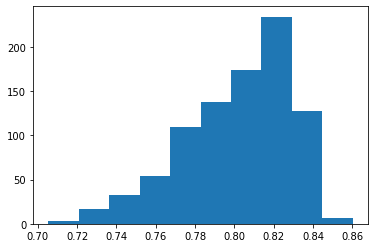


Epoch 20/20
159/159 [==============================] - 3s 20ms/step - loss: 0.0202

*** Epoch 20: Spearman's correlation = 0.1842
*** Epoch 20: MSE = 0.0416


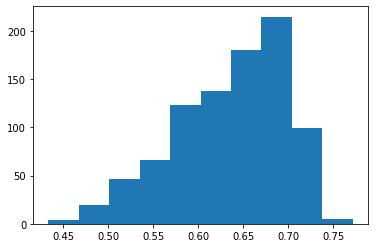

In [16]:
# train model
train_generator = make_generator(X_train, y_train, True, WORKERS).get()
validation_callback = SpearmanCalcCallback(X_test, y_test, BATCH_SIZE, WORKERS)
for attempt in range(TRAINING_ITERATIONS):
    model = functional_model()
    model.compile(
        optimizer='adam',
        loss='mse'
    )
    callbacks = [
        keras.callbacks.TensorBoard(log_dir=os.path.join(logs_dir, "{}".format(time()))),
        validation_callback.set_run(attempt, model)
    ]
    model.fit(train_generator,
              epochs=EPOCHS,
              steps_per_epoch=train_size//BATCH_SIZE,
              callbacks=callbacks)